<a href="https://colab.research.google.com/github/sgrubas/NES/blob/main/notebooks/EikoNet_NES-TP_Marmousi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----
# Comparison of NES-TP and EikoNet on Marmousi model
----
Open in [Colab](https://colab.research.google.com/github/sgrubas/NES/blob/main/notebooks/EikoNet_NES-TP_Marmousi.ipynb)

In [1]:
!pip install git+https://github.com/Ulvetanna/EikoNet.git # EikoNet
!pip install eikonalfm==0.9.5 # for reference solution (2nd-order factored FMM)
!pip install git+https://github.com/sgrubas/NES.git # Neural Eikonal Solver

import numpy as np
import tensorflow as tf
import torch
from tqdm.keras import TqdmCallback # progress bar
from eikonalfm import factored_fast_marching as ffm # reference solution
from eikonalfm import distance # reference solution
import NES # Neural Eikonal Solver
from EikoNet import model as EikoNet # EikoNet
import holoviews as hv # for visualization
hv.extension('matplotlib')
from IPython.display import clear_output
clear_output()

# Uploading velocity model
---

In [2]:
# Since EikoNet by default is applied for 3D models, we create pseudo 3D model of Marmousi 
# import 2D model
Vel2D = NES.misc.Marmousi(smooth=3, section=[[600, 881], None]) # importing from NES package data
vmin, vmax = Vel2D.min, Vel2D.max
xmin, zmin = Vel2D.xmin
xmax, zmax = Vel2D.xmax
nx, nz = 281, 281
x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
Xr_2d = np.stack(np.meshgrid(x, z, indexing='ij'), axis=-1)
V_2d = Vel2D(Xr_2d)

# converting to pseudo 3D
y = np.array([0.0, 1e-3])
V_3d = np.tile(V_2d[..., None], reps=(1, 1, len(y)))

Xr_3d = np.stack(np.meshgrid(x, z, y, indexing='ij'), axis=-1)
Vel3D = NES.Interpolator(V_3d, x, z, y)

In [3]:
# Adaptation for EikoNet format
class EikoNetVelocity:
  def __init__(self, Vel):
    self.xmin = Vel.xmin
    self.xmax = Vel.xmax
    self.projection = None
    self.f = Vel
  def eval(self, Xp):
    Yp  = np.zeros((Xp.shape[0], 2))
    Yp[:, 0] = self.f(Xp[:,:3])
    Yp[:, 1] = self.f(Xp[:,3:])
    return Yp

EikoNet_Vel3D = EikoNetVelocity(Vel3D)

# Reference solution - second-order factored FMM
___
For details see [github source](https://github.com/kevinganster/eikonalfm)

In [4]:
# Test source locations
Ixs = [
       (nx//9, nz//9, 0), 
       (nx//2, nz//2, 0), 
       (int(nx//1.1), int(nz//1.1), 0)
       ]
d = [x[1]-x[0], z[1]-z[0], y[1]-y[0]]
T_ref = []

for ixs in Ixs:
  D = distance(V_3d.shape, d, ixs, indexing='ij')[..., 0]
  T_ref.append(D * ffm(V_3d, ixs, d, 2)[..., 0])
T_ref = np.stack(T_ref, axis=0)

In [5]:
xr = Xr_3d[..., 0, :]
Xs = [np.tile(Xr_3d[ixs][None, None, ...], xr.shape[:-1] + (1,)) for ixs in Ixs]
Xp = [np.concatenate([xsi, xr], axis=-1) for xsi in Xs]
X_test = np.stack(Xp, axis=0)

# NES-TP solution
---
For details see [paper](https://arxiv.org/abs/2205.07989) 

In [6]:
NES_TP = NES.NES_TP(velocity=Vel3D)
NES_TP.build_model(nl=6, nu=100)

2024-10-08 09:45:46.627509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-08 09:45:46.628037: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
%%time
history = NES_TP.train(x_train=25000, # number of collocation points for training
                       callbacks=[TqdmCallback(verbose=0, miniters=10)],
                       epochs=1000, verbose=0,
                       batch_size=25000)

100%|██████████| 1000/1000 [01:39<00:00, 10.03epoch/s, loss=0.0332]

CPU times: user 44min 59s, sys: 30.9 s, total: 45min 30s
Wall time: 1min 39s


In [8]:
NES_loss = history.history['loss']# Recommended GPU memory ~ 16 GB
T_nes = NES_TP.Traveltime(X_test, verbose=1)

3/3 [==============================] - 0s 40ms/step


# EikoNet solution
---
For details see [paper](https://arxiv.org/pdf/2004.00361.pdf)

This may require ~16 GB of GPU memory for training and ~25 GB of CPU RAM for prediction

In [12]:
filePath = './data'
model = EikoNet.Model(filePath, VelocityClass=EikoNet_Vel3D, device='cuda:0')
model.Params['Training']['Number of sample points'] = 25000 # number of collocation points for training
model.Params['Training']['Save Every * Epoch'] = 1e6
model.Params['Training']['Print Every * Epoch'] = 100
model.Params['Training']['Number of Epochs'] = 1000

In [13]:
%%time
model.train()
EikoNet_loss = model.total_train_loss

(25000, 6) (25000, 2)
cuda:0
========================== Eikonal Solver - Training ==================================
Epoch = 100 -- Training loss = 8.8510e-02 -- Validation loss = 4.9495e-02
Epoch = 200 -- Training loss = 8.8084e-02 -- Validation loss = 4.9809e-02
Epoch = 300 -- Training loss = 8.7755e-02 -- Validation loss = 4.9868e-02
Epoch = 400 -- Training loss = 8.6610e-02 -- Validation loss = 4.8695e-02
Epoch = 500 -- Training loss = 8.8041e-02 -- Validation loss = 4.9344e-02
Epoch = 600 -- Training loss = 8.6345e-02 -- Validation loss = 4.8999e-02
Epoch = 700 -- Training loss = 8.6662e-02 -- Validation loss = 4.9232e-02
Epoch = 800 -- Training loss = 8.7370e-02 -- Validation loss = 4.8925e-02
Epoch = 900 -- Training loss = 8.6710e-02 -- Validation loss = 4.9724e-02
Epoch = 1000 -- Training loss = 8.6467e-02 -- Validation loss = 4.9068e-02
CPU times: user 6min 15s, sys: 1.79 s, total: 6min 17s
Wall time: 6min 20s


In [14]:
# After training EikoNet, GPU memory is not cleaned 
# To run it for prediction, we load saved model on CPU to use RAM
# Recommended RAM ~ 25 GB

model2    = EikoNet.Model(filePath, EikoNet_Vel3D, device='cpu')
# Please, input proper name of saved model
saved_model_name = 'Model_Epoch_01000_ValLoss_0.04906758852303028.pt'
model2.load(filePath + '/' + saved_model_name) 

Xpt = torch.tensor(np.float32(X_test.reshape(-1, 6)))
TT = model2.TravelTimes(Xpt)
T_eikonet = TT.detach().numpy().reshape(len(Ixs), nx, nz)

/home/mop/.local/lib/python3.10/site-packages/EikoNet/model.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint            = torch.load(filepath,map_location=to

# Visualization
---

In [15]:
print("RMAE of NES-TP =", 100 * abs(T_ref - T_nes).mean() / T_ref.mean(), '%')
print("RMAE of EikoNet =", 100 * abs(T_ref - T_eikonet).mean() / T_ref.mean(), '%')

RMAE of NES-TP = 1.0488880820165782 %
RMAE of EikoNet = 3.1035188818177133 %


## Loss curves

:Layout
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)
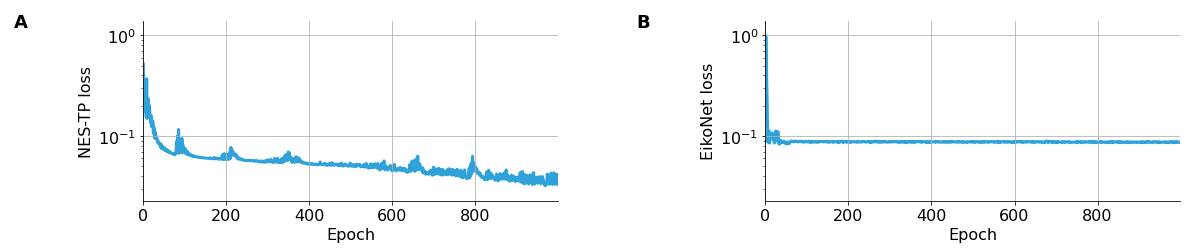

In [16]:
figs = [hv.Curve(NES_loss).opts(ylabel='NES-TP loss'), 
        hv.Curve(EikoNet_loss).opts(ylabel='EikoNet loss')]
fig = hv.Layout(figs).cols(2).opts(hv.opts.Curve(logy=True, show_grid=True, 
                                                 linewidth=3,
                                                 xlabel='Epoch', fig_size=250, 
                                                 fontsize=dict(labels=16, ticks=16, 
                                                               title=18)))
fig.opts(fig_size=200)

## Solution contours

:Layout
   .Overlay.I   :Overlay
      .Image.I                      :Image   [X (km),Z (km)]   (Velocity (km/s))
      .Contours.F_hyphen_minus_FMM  :Contours   [x,y]   (Time (s))
      .Contours.NES_hyphen_minus_TP :Contours   [x,y]   (Time (s))
      .Contours.EikoNet             :Contours   [x,y]   (Time (s))
      .Scatter.I                    :Scatter   [x]   (y)
   .Overlay.II  :Overlay
      .Image.I                      :Image   [X (km),Z (km)]   (Velocity (km/s))
      .Contours.F_hyphen_minus_FMM  :Contours   [x,y]   (Time (s))
      .Contours.NES_hyphen_minus_TP :Contours   [x,y]   (Time (s))
      .Contours.EikoNet             :Contours   [x,y]   (Time (s))
      .Scatter.I                    :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Image.I                      :Image   [X (km),Z (km)]   (Velocity (km/s))
      .Contours.F_hyphen_minus_FMM  :Contours   [x,y]   (Time (s))
      .Contours.NES_hyphen_minus_TP :Contours   [x,y]   (Time (s))
      .Contours.EikoNet             :Contours   [x,y]   (Time (s))
      .Scatter.I                    :Scatter   [x]   (y)
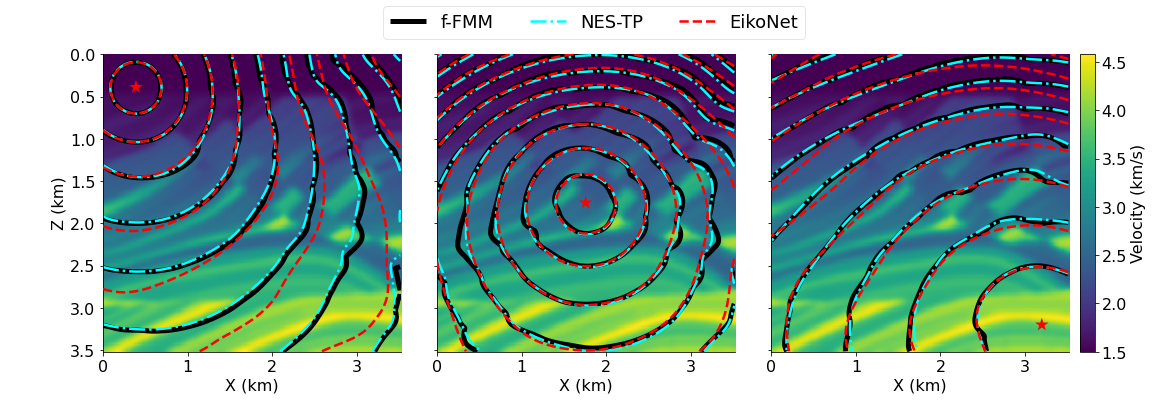

In [17]:
figs = []

labels = ['f-FMM', 'NES-TP', 'EikoNet']

colors = ['#000000', '#00FFFF', '#FF0000']
linestyles = ['solid', '-.', 'dashed']
linewidths = [5, 2.5, 2.5]

for t_ref, t_nes, t_eikonet in zip(T_ref, T_nes, T_eikonet):
  ixs = np.unravel_index(t_ref.argmin(), t_ref.shape)
  vmap = hv.Image((x, z, V_2d.T), vdims='Velocity (km/s)', 
                  kdims=['X (km)', 'Z (km)']).opts(cmap='viridis', colorbar=True)

  solutions = [t_ref, t_nes, t_eikonet]
  levels = np.linspace(0, np.nanmax(t_ref), 11)


  tmaps = [hv.Image((x, z, solutions[i].T), 
                    vdims='Time (s)', 
                    label=labels[i])
          for i in range(len(labels))]
  contours = [hv.operation.contours(tmaps[i], levels=levels).opts(color=colors[i],
                                                                  cmap=[colors[i]],
                                                          linestyle=linestyles[i], 
                                                          linewidth=linewidths[i]) 
              for i in range(len(tmaps))]

  source_point = hv.Scatter((x[ixs[0]], z[ixs[1]])).opts(marker='*', s=200, c='r')
  fig = hv.Overlay([vmap] + contours + [source_point])
  fig = fig.opts(hv.opts.Image(fig_size=150, aspect=xmax/zmax, invert_yaxis=True, 
                               fontsize=dict(ticks=16, labels=16, legend=16)))
  figs.append(fig.opts(show_legend=False))

figs[0] = figs[0].opts(hv.opts.Image(colorbar=False)).opts(yaxis='left')
figs[1] = figs[1].opts(hv.opts.Image(colorbar=False)).opts(show_legend=True,yaxis="bare",
                                                    legend_opts=dict(loc=(-0.18, 1.05), 
                                                    ncol=3, framealpha=0.5),
                fontsize=dict(ticks=16, labels=16,legend=18))
figs[2] = figs[2].opts(hv.opts.Image(yaxis="bare"), hv.opts.Scatter(yaxis="bare"))
fig = hv.Layout(figs).cols(3).opts(hspace=0.1, fig_size=125, aspect_weight=1, sublabel_format=' ')
fig